# notebook 5: initial grid search for `Waddington-OT`
_Langevin dynamics on 2d-Waddington volcano_

## imports

### mount drive

In [1]:
COLAB = False
if COLAB == True:
    drive.mount('/content/drive')

### pip installs

In [2]:
if COLAB==True:
    !pip install scanpy moscot ott-jax diffrax napari anndata -q
    !pip install "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
else:
    pass 

### set save directories

In [3]:
fh_save_data = './volcano_data_saved/'
fh_save_output = './volcano_output_saved/'
fh_save_metrics = './volcano_metrics_saved/'

print(f"save data file path: {fh_save_data}")
print(f"save output file path: {fh_save_output}")
print(f"save metrics file path: {fh_save_metrics}")

save data file path: ./volcano_data_saved/
save output file path: ./volcano_output_saved/
save metrics file path: ./volcano_metrics_saved/


### imports

In [4]:
import sys
import pathlib
import os
import random
import importlib

import pickle
import pandas as pd
from anndata import AnnData
import scanpy as sc

import random
import numpy as np
from typing import Tuple
import torch
import scipy
scipy.matrix = np.matrix # for compatibility with gwot


from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans
from threadpoolctl import threadpool_limits

# import plotly.graph_objects as go
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from PIL import Image

import jax
import jax.numpy as jnp
from jax import random as jax_random
import moscot as mt
import moscot.plotting as mpl
from moscot.problems.time import TemporalProblem

# import gwot
from gwot import models

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### import `HM-OT`

In [5]:
if COLAB == True:
    fh_hmot = "/content/drive/Othercomputers/numac/GitHub/HM-OT" # filehandle for HM-OT
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)
    sys.path.insert(0, str(project_root / "src"))
else: 
    fh_hmot = '../../'
    project_root = pathlib.Path(fh_hmot)
    sys.path.insert(0, fh_hmot)

import src.FRLC as FRLC
import src.FRLC.FRLC_multimarginal as FRLC_multimarginal
import src.HiddenMarkovOT as HiddenMarkovOT

import src.utils.clustering as clustering
import src.utils.util_LR as util_LR
import src.utils.util_zf as util_zf

from src.validation import trajectory_validation as tv 
from src.utils.util_LR import convert_adata
from src.utils.waddington import visual, minima, simulation, differentiation, metrics, landscape_core_volcano, landscape_core_tristable
# TODO: minima is currently the home of function setup_point_clouds_for_waddington_ot
from src.utils.waddington import seed_everything
from src.platting import color_utils, palette_utils, string_utils, spatial_scatter, diffmap, sankey
# import src.plotting as plotting
import experiments.differentiation_map_validation as dmv # for cosine similarity


## settings: `GLOBAL_SEED`, `device`, `dtype`

### set seed

In [6]:
# Set global seed for reproducibility
GLOBAL_SEED = 42
# np.random.seed(GLOBAL_SEED)
seed = seed_everything(GLOBAL_SEED)

🌱 Setting global seed to 42
  ✓ PyTorch seeded
  ✓ JAX PRNG key created
🌱 All available RNGs seeded.


### reload / set `device`, `dtype`

In [7]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(HiddenMarkovOT)
importlib.reload(dmv)

<module 'experiments.differentiation_map_validation' from '/Users/normandie/Documents/GitHub/HM-OT/experiments/volcano/../../experiments/differentiation_map_validation.py'>

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64
dtype_np = np.float64

On device: cpu


## load Langevin dynamics, ground truth $Q$'s and $T$'s, all parameters
Langevin dynamics: trajectory data with no measurement noise

Assignment radius: 1.6
Verification (polar coords):
(-1.564, -2.709)  r= 3.13  θ= 240.0° → A240
( 3.128,  0.000)  r= 3.13  θ=   0.0° → A0
(-1.564,  2.709)  r= 3.13  θ= 120.0° → A120
(-4.799, -2.796)  r= 5.55  θ= 210.2° → B210
(-4.799,  2.796)  r= 5.55  θ= 149.8° → B150
( 4.821, -2.758)  r= 5.55  θ= 330.2° → B330
( 4.821,  2.758)  r= 5.55  θ=  29.8° → B30
(-0.022, -5.555)  r= 5.55  θ= 269.8° → B270
(-0.022,  5.555)  r= 5.55  θ=  90.2° → B90
(-7.705, -4.448)  r= 8.90  θ= 210.0° → C210
( 7.705, -4.448)  r= 8.90  θ= 330.0° → C330
( 7.705,  4.448)  r= 8.90  θ=  30.0° → C30
(-7.705,  4.448)  r= 8.90  θ= 150.0° → C150
(-0.000, -8.897)  r= 8.90  θ= 270.0° → C270
(-0.000,  8.897)  r= 8.90  θ=  90.0° → C90


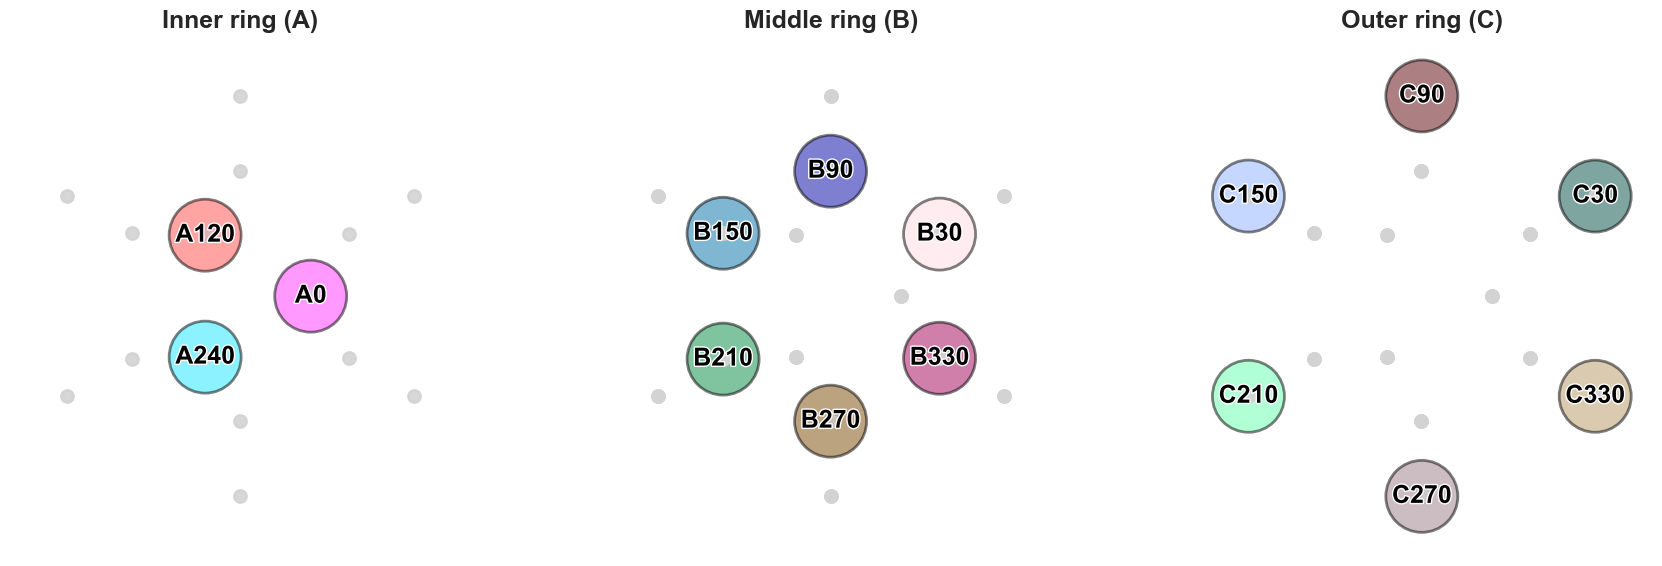


Total clusters: 15
CPU times: user 1 s, sys: 108 ms, total: 1.11 s
Wall time: 1.14 s


In [9]:
%%time

# timepoint indices of snapshots of Langevin dynamics
TIMEPOINTS = [16, 89, 3500] # snapshots taken at these timepoints

# Langevin dynamics parameteters
LANGEVIN_n_particles = 1000 # number of partciles
LANGEVIN_N_timesteps = 4000 # number of time steps
LANGEVIN_dt = 0.2
LANGEVIN_D = 0.014

# local minima of the Waddington landscape
# (+ ASSIGNMENT_RADIUS) determine cell type
MINIMA_POINTS = minima.find_local_minima()
ASSIGNMENT_RADIUS = 1.6

# Load all datasets across all noise levels
with open(fh_save_data + 'datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    Ss = datasets[0] # Ss is the first dataset, which is the original data without noise
    f.close()

# Load ground-truth Qs and Ts with no cell types removed (1000 particles)
with open(fh_save_data + 'Ts_gt_global.pkl', 'rb') as f:
    Ts_gt_global = pickle.load(f)
    f.close()

with open(fh_save_data + 'Qs_gt_global.pkl', 'rb') as f:
    Qs_gt_global = pickle.load(f)
    f.close()

# Load ground-truth Qs and Ts after removing small cell types (915 particles)
with open(fh_save_data + 'Ts_gt_reduced.pkl', 'rb') as f:
    Ts_gt_reduced = pickle.load(f)
    f.close()

with open(fh_save_data + 'Qs_gt_reduced.pkl', 'rb') as f:
    Qs_gt_reduced = pickle.load(f)
    f.close()

# Load good rows, rank list, Xs and Ys
with open(fh_save_data + 'GOOD_ROWS.pkl', 'rb') as f:
    GOOD_ROWS = pickle.load(f)
    f.close()

with open(fh_save_data + 'RANK_LIST.pkl', 'rb') as f:
    RANK_LIST = pickle.load(f)
    f.close()

with open(fh_save_data + 'Xs.pkl', 'rb') as f:
    Xs = pickle.load(f)
    f.close()

with open(fh_save_data + 'Ys.pkl', 'rb') as f:
    Ys = pickle.load(f)
    f.close()

# construct canonical labels, colormap
STR_TO_IND_DICT_GLOBAL = { v: k \
                          for k, v in minima.IND_TO_STR_DICT_GLOBAL.items() }
_, _, _, IND_TO_COLOR_DICT_GLOBAL = palette_utils.get_diffmap_inputs(Qs_gt_global, 
                                                                     Ts_gt_global, 
                                                                     global_Qs=True)
STR_TO_COLOR_DICT_GLOBAL = {k : IND_TO_COLOR_DICT_GLOBAL[v] \
                            for k, v in STR_TO_IND_DICT_GLOBAL.items()}


CLUSTER_DICT = visual.create_cluster_dict_and_plot(
    MINIMA_POINTS,
    ASSIGNMENT_RADIUS,
    str_to_color_dict=STR_TO_COLOR_DICT_GLOBAL
)

# ─────────────────────────────────────────────────────────────────────────────────
# scatter plotting parameters

SCATTER_PAD=1.0
SCATTER_SUBPLOT_SPACING=1.0
SCATTER_FONT_SIZE=48
SCATTER_KEY_SPACING=0.25
SCATTER_DOTSIZE = 400.0
SCATTER_KEY_DOTSIZE = 1.0
LABEL_ORDER = minima.LABEL_ORDER
DOT_ALPHA = 0.8  # opacity of dots
SCATTER_OUTLINE_COLOR = "black"  # outline color for dots

canonical_order = ['U', 'A240', 'A0', 'A120', 'B210', 'B90', 'B330', 'B30', 'B270', 'B150',
                   'C210', 'C330', 'C30', 'C90', 'C270', 'C150']

# Constants for measurement noise levels
STD = 1.0
NOISE_min = 2.0 * STD
NOISE_max = 3.5 * STD
n_TIMEPOINTS = len(TIMEPOINTS)  # Assuming TIMEPOINTS is defined elsewhere
n_noise_levels = 10

n_timepoints = len(TIMEPOINTS)
THRESHOLD = 20.0 # population threshold, below which we remove cell types

# ─────────────────────────────────────────────────────────────────────────────────
# diffmap plotting parameters
LINETHICK_FACTOR = 40
GLOBAL_DIFFMAP_DOTSIZE = 5.0
GLOBAL_DIFFMAP_FONTSIZE = 16
GLOBAL_DIFFMAP_STRETCH = 2.0
GLOBAL_DIFFMAP_OUTLINE = 3.0

##  plot ground truth diffmap

### plotting global diffmap

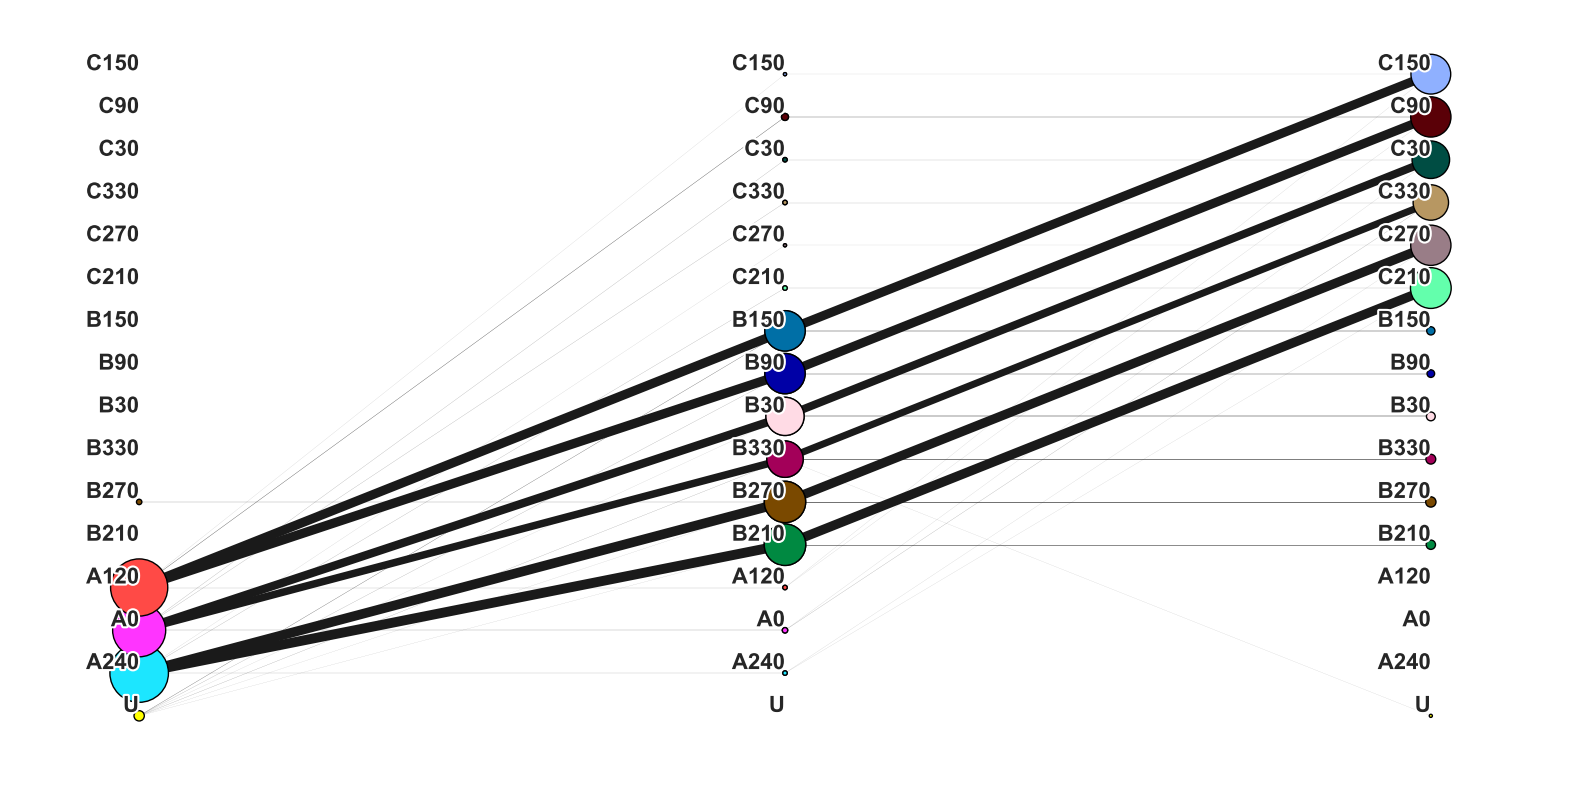

In [10]:
diffmap.diffmap_from_QT(Qs_gt_global, 
                        Ts_gt_global, 
                        global_Qs=True,  
                        ind_to_str_dict=minima.IND_TO_STR_DICT_GLOBAL, 
                        str_to_color_dict=STR_TO_COLOR_DICT_GLOBAL,
                        dotsize=GLOBAL_DIFFMAP_DOTSIZE,
                        linethick_factor=LINETHICK_FACTOR,
                        fontsize=GLOBAL_DIFFMAP_FONTSIZE,
                        stretch=GLOBAL_DIFFMAP_STRETCH,
                        outline=GLOBAL_DIFFMAP_OUTLINE,
                        label_order=LABEL_ORDER,
                        stagger=True)

### plotting reduced diffmap

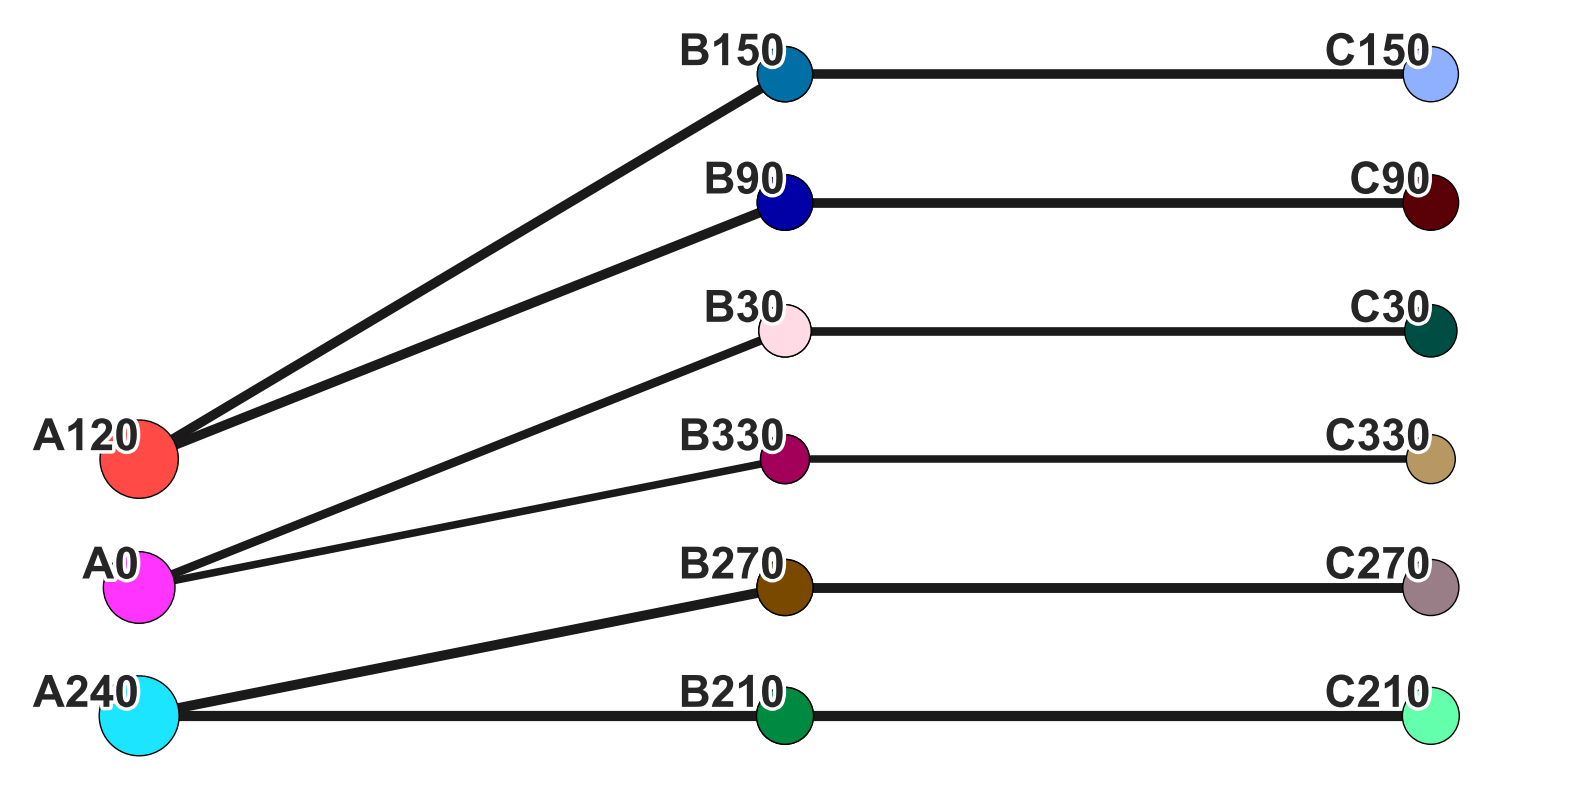

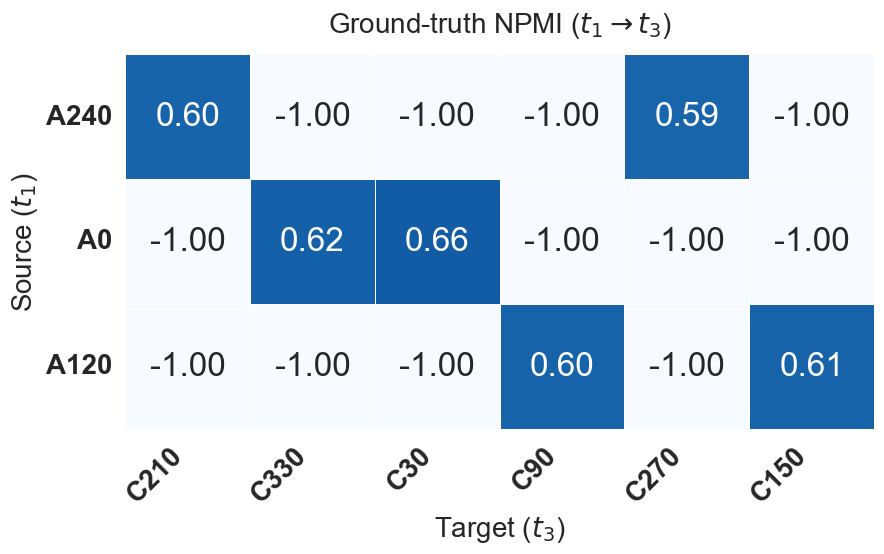

In [11]:
def NPMI_t1_to_t3_matrix(Qs, Ts, labels_Q):
    """
    Compute full matrix of NPMI scores between clusters at timepoint 1 and timepoint 3

    Args:
        Qs: List of soft assignment matrices [Q0, Q1, Q2]
        Ts: List of transition matrices [T01, T12]
        labels_Q: List of string label lists for each timepoint [labels0, labels1, labels2]

    Returns:
        DataFrame with columns ['source', 'target', 'npmi'] for all (t1, t3) cluster pairs.
    """
    Q0, Q1, Q2 = Qs
    T01, T12 = Ts
    labels0, labels1, labels2 = labels_Q

    # Compute composite transition T02 = T01 @ T12
    g0 = np.sum(Q0, axis=0)
    g1 = np.sum(Q1, axis=0)
    g2 = np.sum(Q2, axis=0)

    T02 = T01 @ np.diag(1/g1) @ T12

    total_mass0 = g0.sum()
    total_mass2 = g2.sum()

    npmi_scores = []
    for i_row, src_label in enumerate(labels0):
        for j_col, tgt_label in enumerate(labels2):
            p_joint = T02[i_row, j_col]
            if p_joint > 0:
                p_x = g0[i_row] / total_mass0
                p_y = g2[j_col] / total_mass2
                npmi = dmv.NPMI(p_joint, p_x, p_y)
                npmi_scores.append((src_label, tgt_label, npmi))

    df = pd.DataFrame(npmi_scores, columns=["source", "target", "npmi"])
    return df

NPMI_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],  # time-point 1
    ['B210', 'B90', 'B330', 'B30', 'B270', 'B150'],  # time-point 2
    ['C210', 'C330', 'C30', 'C90', 'C270', 'C150'],  # time-point 3
]

LINETHICK_FACTOR = 40
DIFFMAP_DOTSIZE = 20.0
DIFFMAP_FONTSIZE = 32
DIFFMAP_STRETCH = 2.0
DIFFMAP_OUTLINE = 5.0

# Ground-truth diffmap, with small cell types filtered out
diffmap.diffmap_from_QT([Q * LANGEVIN_n_particles for Q in Qs_gt_reduced], 
                        Ts_gt_reduced, 
                        global_Qs=False,
                        ind_to_str_dict = minima.IND_TO_STR_DICT_EXP,
                        str_to_color_dict = STR_TO_COLOR_DICT_GLOBAL,
                        linethick_factor=LINETHICK_FACTOR,
                        dotsize=0.5 * DIFFMAP_DOTSIZE,
                        stretch=DIFFMAP_STRETCH,
                        fontsize=DIFFMAP_FONTSIZE,
                        outline=DIFFMAP_OUTLINE,
                        label_order=minima.LABEL_ORDER)

FONTSIZE = 20
cmap = "Blues"

# ── Build the matrix exactly as before ───────────────────────────────────────
canonical_order = [
    "A240", "A0", "A120", "B210", "B90", "B330", "B30", "B270", "B150",
    "C210", "C330", "C30", "C90", "C270", "C150",
]
gt_NPMI_df = NPMI_t1_to_t3_matrix(Qs_gt_reduced, Ts_gt_reduced, NPMI_VALLEYS_LIST)
gt_npmi_matrix_ = gt_NPMI_df.pivot(index="source", columns="target", values="npmi")

row_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[0]]
col_labels = [l for l in canonical_order if l in NPMI_VALLEYS_LIST[2]]
gt_npmi_matrix = (
    gt_npmi_matrix_.reindex(index=row_labels, columns=col_labels)
    .fillna(-1)
)
vmin, vmax = -1.0, 1.0

# ── Single-axes plot ────────────────────────────────────────────────────────
sns.set_theme(style="white", context="notebook")

fig, ax = plt.subplots(figsize=(9, 9))

# NPMI heatmap
sns.heatmap(
    gt_npmi_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    linewidths=0.5,
    linecolor="white",
    square=True,
    ax=ax,
    cbar=False,
    annot_kws={"size": 24},
)

ax.set_title(
    rf"Ground-truth NPMI ($t_1 \rightarrow t_3$)",
    fontsize=FONTSIZE,
    pad=16,
)
ax.set_xlabel("Target ($t_3$)", fontsize= FONTSIZE)
ax.set_ylabel("Source ($t_1$)", fontsize= FONTSIZE)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=FONTSIZE, weight="bold")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=FONTSIZE, weight="bold")

plt.tight_layout()
plt.show()

## cluster registration via assignment problem

In [12]:
def solve_assignment_problem(points1, points2):
    """
    Solve the assignment problem between two point clouds.
    
    Parameters:
    points1: numpy array of shape (n, 2) - first point cloud
    points2: numpy array of shape (n, 2) - second point cloud
    
    Returns:
    permutation_matrix: numpy array of shape (n, n) - binary permutation matrix
                       where entry (i,j) = 1 means point i from points1 is assigned to point j from points2
    """
    # Compute pairwise distances between all points
    cost_matrix = cdist(points1, points2, metric='euclidean')
    
    # Solve the assignment problem using Hungarian algorithm
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Create permutation matrix
    n = len(points1)
    permutation_matrix = np.zeros((n, n), dtype=int)
    permutation_matrix[row_indices, col_indices] = 1
    
    return permutation_matrix

def get_barycenters(Q, S):
    Q_col_stochastic = Q @ np.diag(1 / Q.sum(axis=0))
    barycenters = Q_col_stochastic.T @ S
    return barycenters

def get_registration(Qs, Ss, cluster_dict):
    """
    registers the barycenters of Qs to the ordered valleys in cluster_dict.
    Returns a list of permutations for each timepoint.
    """
    ordered_valleys = np.array(list(cluster_dict.keys()))
    permutation_list = []

    start = 0
    end = Qs[0].shape[1]

    for t, Q in enumerate(Qs):
        barycenters = get_barycenters(Q, Ss[t]) 
        valleys = ordered_valleys[start:end]
        permutation_matrix = solve_assignment_problem(barycenters, valleys)
        permutation_list.append(permutation_matrix)
        start = end
        end += Qs[t + 1].shape[1] if t + 1 < len(Qs) else 0

    return permutation_list

## for viewing grid search output

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def pivot_metric(df, metric):
    return (df.pivot(index='tau', columns='eps', values=metric)
              .sort_index(axis=0)
              .sort_index(axis=1))

def sci_annot(df, digits=2):
    return df.applymap(lambda v: f"{v:.{digits}e}")

def annotate_min(ax, data, star_size=22, edgecolor='cyan', lw=2):
    i_min, j_min = np.unravel_index(np.nanargmin(data.values), data.shape)
    ax.text(j_min, i_min, "*", ha='center', va='center', fontsize=star_size, color='cyan')
    ax.add_patch(Rectangle((j_min, i_min), 1, 1, fill=False, edgecolor=edgecolor, lw=lw))

def plot_heatmap(df, metric, title,
                 annot_size=11, star_size=22,
                 figsize=(8.5, 6.5), digits=2):
    mat = pivot_metric(df, metric)
    fig, ax = plt.subplots(figsize=figsize)

    sns.heatmap(
        mat.T,
        annot=sci_annot(mat, digits),  # provide formatted strings
        fmt="",
        annot_kws={"size": annot_size, "weight": "bold"},
        cbar_kws={},
        cmap='rocket_r',
        ax=ax
    )

    annotate_min(ax, mat.T, star_size=star_size)

    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel(r"$\tau$", fontsize=14)
    ax.set_ylabel(r"$\epsilon$", fontsize=14)

    # ticks in sci notation
    ax.tick_params(labelsize=11)
    ax.set_xticklabels([f"{x:.1e}" for x in mat.T.columns], rotation=60, ha='right')
    ax.set_yticklabels([f"{y:.1e}" for y in mat.T.index])

    plt.tight_layout()
    return fig, ax

## experiment loop: `W-OT` run with diffmap and cluster viz

Note that the paramters $\epsilon$, $\tau_a, \tau_b$ are involved in the objective function specifically as follows:
$$
\mathrm{arg}\,\min_{
    P \in \mathbb{R}_+^{N \times M}
} 
\langle C, P \rangle
+ \frac{\epsilon \tau_a}{1-\tau_a}
\mathrm{KL}( P \bm{1}_M \mid a ) 
+
\frac{\epsilon \tau_b}{1-\tau_b}
\mathrm{KL}( P^\top \bm{1}_N \mid b) -
\epsilon H(P)
$$

noise level 1 / 10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
plotting (W-OT + $k$-means) diffmap for noise level = 2.0


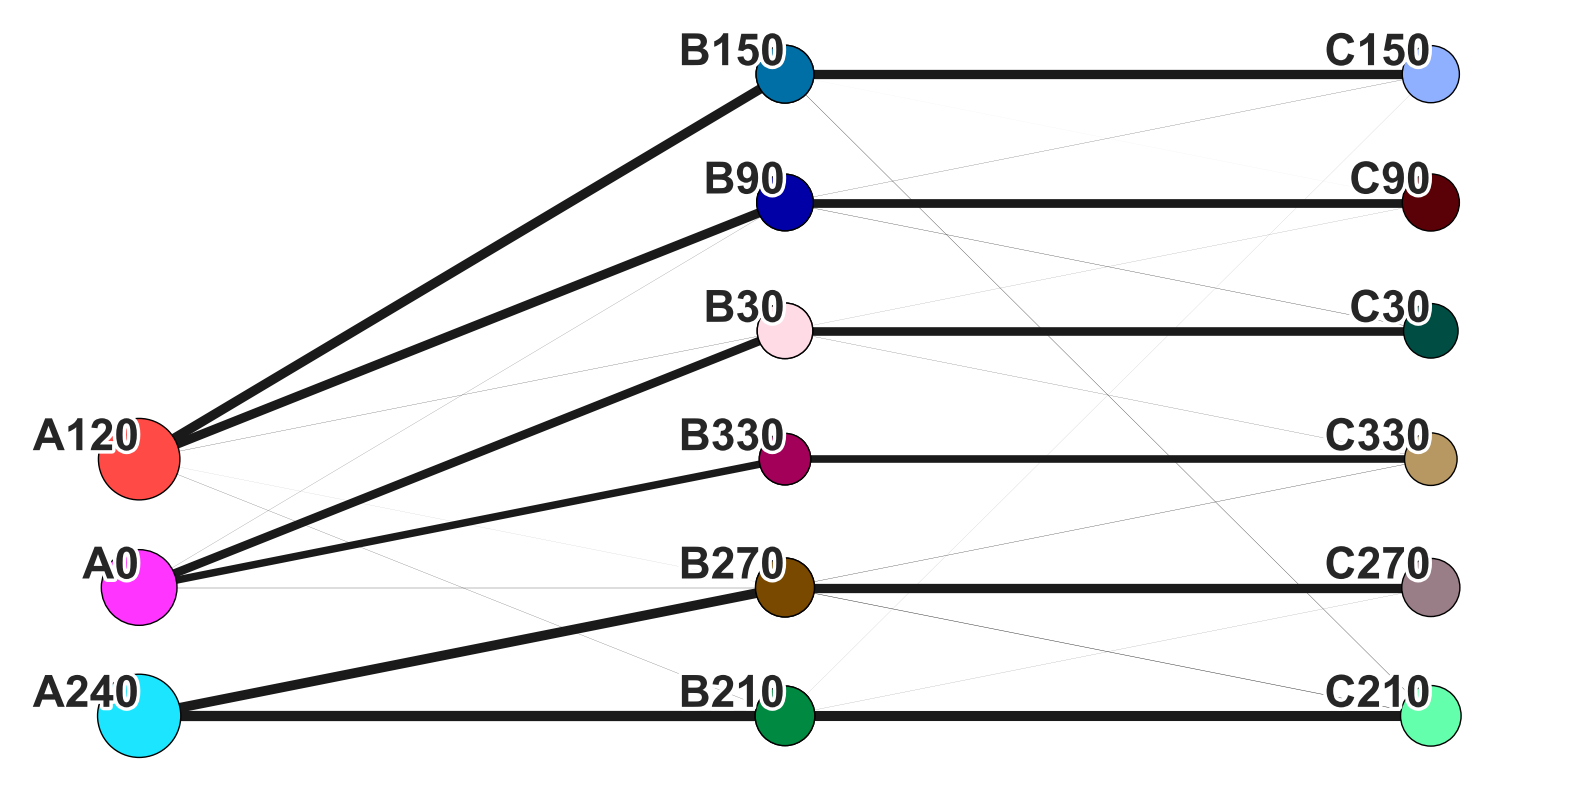

k-means clusters for noise level = 2.0


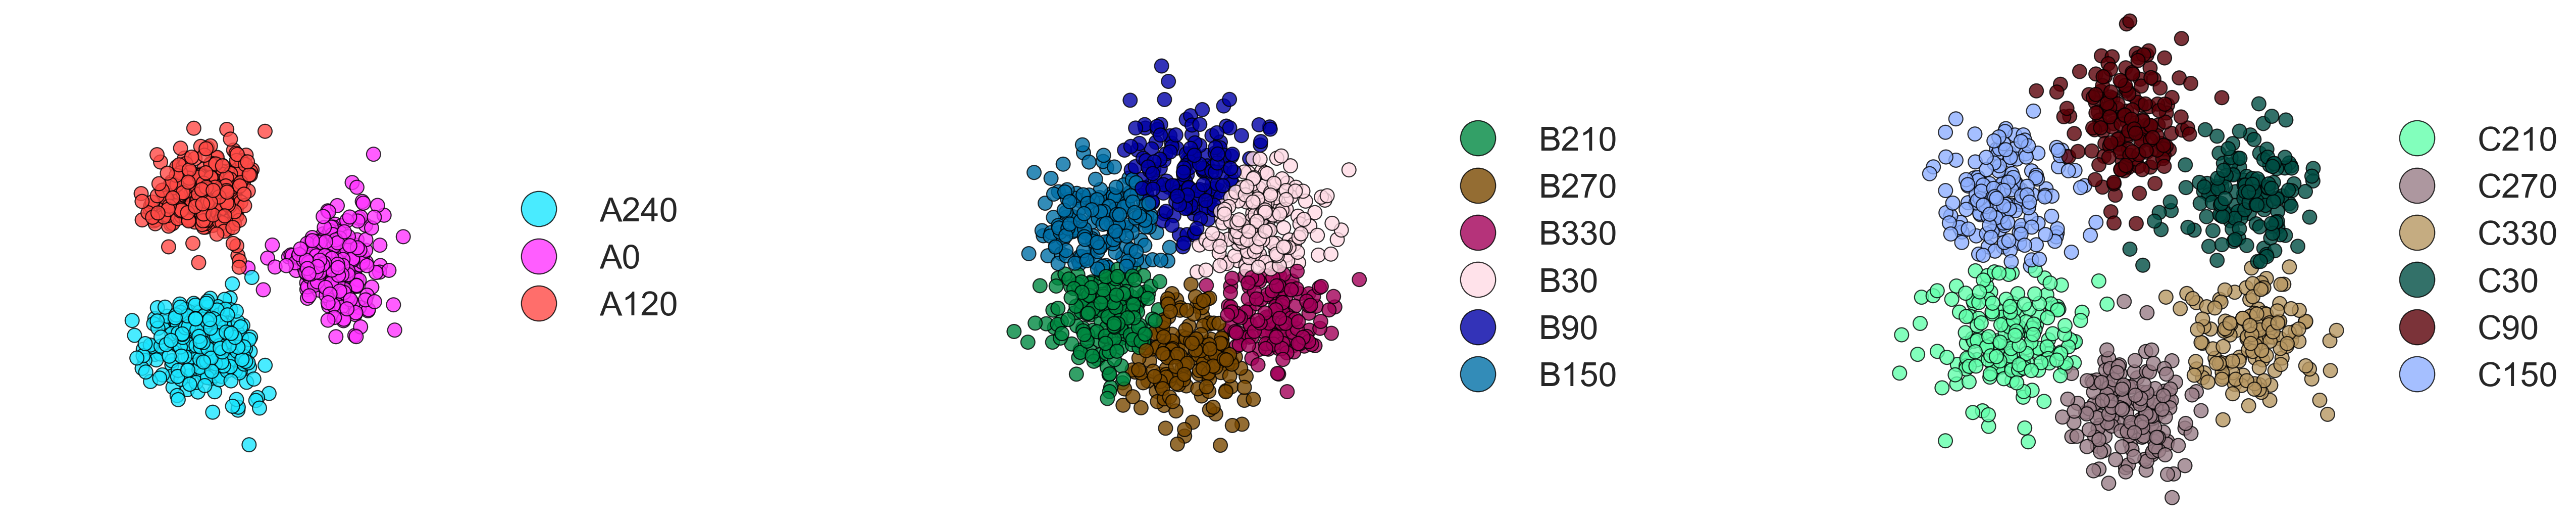

CPU times: user 25.8 s, sys: 721 ms, total: 26.6 s
Wall time: 21.5 s


In [14]:
%%time
SHOW_PLOTS = True 
noise_level_range = np.linspace(NOISE_min, NOISE_max, n_noise_levels)

ITER = 60
GAMMA = 200.0
ALPHA = 0.0
TAU_IN = 10


WOT_eps = 1e-4
WOT_tau_a = 1.0
WOT_tau_b = WOT_tau_a

GWOT_dt = 1.0
GWOT_eps_df = 1e-4 # gwot entropy regularization parameter for data fitting (df) OT
GWOT_lamda_reg = 0.0025
GWOT_D = 0.025

ALLOWED_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],  # time-point 1
    ['B210', 'B150', 'B330', 'B90', 'B30', 'B270'],  # time-point 2
    ['C210', 'C330', 'C30', 'C150', 'C270', 'C90'],  # time-point 3
]

STR_TO_VALLEY_DICT = { 
    v : k for k, v in CLUSTER_DICT.items()
}

km_Qs_list = []
wot_Ts_list = []

wot_12_Frobs_list = []
wot_23_Frobs_list = []

for i, level in enumerate(noise_level_range[:1]):
    torch.manual_seed(GLOBAL_SEED)
    print(f'noise level {i+1} / {len(noise_level_range)}: {level}')
    # create noisy snapshots
    Ss_noisy = datasets[i+1]

    with threadpool_limits(limits=1):
        # run k-means clustering
        k1 = KMeans(n_clusters=RANK_LIST[0][0], algorithm="lloyd", n_init=1, random_state=GLOBAL_SEED)
        k2 = KMeans(n_clusters=RANK_LIST[0][1], algorithm="lloyd", n_init=1, random_state=GLOBAL_SEED)
        k3 = KMeans(n_clusters=RANK_LIST[1][1], algorithm="lloyd", n_init=1, random_state=GLOBAL_SEED)
        # extract k-means labels
        klabels1_ = k1.fit_predict(Ss_noisy[0])
        klabels2_ = k2.fit_predict(Ss_noisy[1])
        klabels3_ = k3.fit_predict(Ss_noisy[2])

    # encode labels as matrices
    Q1_km = np.eye(len(set(klabels1_)))[klabels1_]
    Q2_km = np.eye(len(set(klabels2_)))[klabels2_]
    Q3_km = np.eye(len(set(klabels3_)))[klabels3_]

    Qs_km = [Q1_km, Q2_km, Q3_km]
    Perms_km = get_registration(Qs_km, Ss, CLUSTER_DICT) # register k-means clusters

    Qs_reg_km = [ (Q @ Perm) / Q.sum()  for Perm, Q in zip(Perms_km, Qs_km) ] # normalize to sum to 1
    labels_reg_km = [ Q.argmax(axis=1) for Q in Qs_reg_km]
    labels_reg_km1, labels_reg_km2, labels_reg_km3 = labels_reg_km[0], labels_reg_km[1], labels_reg_km[2]

    # append k-means latent representations
    km_Qs_list.append(Qs_reg_km)
    
    # ────────────────────────────────────────────────────────────────────────────────
    # setup data for W-OT
    adata_12 = minima.setup_point_clouds_for_waddington_ot(Ss_noisy[0], Ss_noisy[1], ct_labels_1=labels_reg_km[0], ct_labels_2=labels_reg_km[1])
    adata_12.obs["celltype"] = adata_12.obs["celltype"].astype("category")
    adata_23 = minima.setup_point_clouds_for_waddington_ot(Ss_noisy[1], Ss_noisy[2], ct_labels_1=labels_reg_km[1], ct_labels_2=labels_reg_km[2])
    adata_23.obs["celltype"] = adata_23.obs["celltype"].astype("category")
    tp_12 = mt.problems.time.TemporalProblem(adata_12)
    tp_23 = mt.problems.time.TemporalProblem(adata_23)
    tp_12.prepare(time_key='time_point')
    tp_23.prepare(time_key='time_point')

    solve_kwargs = {
        'epsilon': WOT_eps,
        'tau_a': WOT_tau_a,
        'tau_b': WOT_tau_b,
    }
    # ────────────────────────────────────────────────────────────────────────────────
    # running W-OT
    print(f"running W-OT for noise level = {level}")
    tp_12.solve(**solve_kwargs)
    P_wot_12 = tp_12.solutions[(0, 1)].transport_matrix
    tp_23.solve(**solve_kwargs)
    P_wot_23 = tp_23.solutions[(0, 1)].transport_matrix

    T_wot_12, _, _ = tv.P_to_T(P_wot_12, labels_reg_km1, labels_reg_km2)
    T_wot_23, _, _ = tv.P_to_T(P_wot_23, labels_reg_km2, labels_reg_km3)
    Ts_reg_wot = [T_wot_12, T_wot_23]

    # compute Frobenius norms
    wot_Frob_12 = np.linalg.norm(T_wot_12 - Ts_gt_reduced[0], ord='fro')
    wot_Frob_23 = np.linalg.norm(T_wot_23 - Ts_gt_reduced[1], ord='fro')

    # append results to lists
    wot_Ts_list.append(Ts_reg_wot)
    
    if SHOW_PLOTS:
        # plot W-OT diffmap
        print(f"plotting (W-OT + $k$-means) diffmap for noise level = {level}")
        diffmap.diffmap_from_QT(Qs_reg_km, 
                                Ts_reg_wot, 
                                global_Qs=False,
                                ind_to_str_dict=minima.IND_TO_STR_DICT_EXP,
                                str_to_color_dict=STR_TO_COLOR_DICT_GLOBAL,
                                dotsize=0.5 *DIFFMAP_DOTSIZE,
                                linethick_factor=LINETHICK_FACTOR,
                                stretch=DIFFMAP_STRETCH,
                                fontsize=DIFFMAP_FONTSIZE,
                                outline=DIFFMAP_OUTLINE,
                                label_order=LABEL_ORDER)

            # ────────────────────────────────────────────────────────────────────────────────
        # visualize k-means clusters
        print(f"k-means clusters for noise level = {level}")
        spatial_scatter.plot_clusters_from_QT(
            Qs = Qs_reg_km,
            Ts = [None, None],
            Ss=Ss_noisy,
            ind_to_str_dict = minima.IND_TO_STR_DICT_EXP,
            str_to_color_dict = STR_TO_COLOR_DICT_GLOBAL,
            dotsize=SCATTER_DOTSIZE,
            key_dotsize=SCATTER_KEY_DOTSIZE,
            fontsize=SCATTER_FONT_SIZE,
            pad=SCATTER_PAD,
            subplot_spacing=SCATTER_SUBPLOT_SPACING,
            key_spacing=SCATTER_KEY_SPACING,
            global_Qs=False,
            label_order=LABEL_ORDER,
            outline_color=SCATTER_OUTLINE_COLOR,
            dot_alpha=DOT_ALPHA)
          


## experiment loop: full `W-OT` grid search

In [15]:
from tqdm import tqdm
# --------------------------- PARAM LISTS --------------------------------------
eps_c = 1e-4
tau_c = 0.99999  # Changed from 1.0 to avoid numerical issues

# Zoom factors around center
eps_lo_fac, eps_hi_fac = 0.01, 100.0  
tau_lo_fac, tau_hi_fac = 0.5, 1

# Generate parameter lists
WOT_eps_list = list(eps_c * np.geomspace(eps_lo_fac, eps_hi_fac, 8))
WOT_tau_list = list(tau_c * np.linspace(tau_lo_fac, tau_hi_fac, 8))  # Linear spacing for tau

# ------------------------------------------------------------------------------

ALLOWED_VALLEYS_LIST = [
    ['A240', 'A0', 'A120'],                               # t1
    ['B210', 'B150', 'B330', 'B90', 'B30', 'B270'],       # t2
    ['C210', 'C330', 'C30', 'C150', 'C270', 'C90'],       # t3
]

STR_TO_VALLEY_DICT = {v: k for k, v in CLUSTER_DICT.items()}

from itertools import product
from threadpoolctl import threadpool_limits
from sklearn.cluster import KMeans
import torch
import numpy as np
import pandas as pd


def setup_grid_search_dataframe(
    WOT_tau_list,
    WOT_eps_list,
):
    # Precompute parameter pairs
    param_combinations = list(product(WOT_tau_list, WOT_eps_list))

    rows = []

    for tau, eps in tqdm(param_combinations):
        print(f"\n=== τ={tau:.6g}, ε={eps:.6g} ===")
        wot_12_Frobs_temp = []
        wot_23_Frobs_temp = []
        wot_Frobs_temp = []

        for i, level in enumerate(noise_level_range[:1]):
            torch.manual_seed(GLOBAL_SEED)

            print(f'  noise level {i+1}/{len(noise_level_range)}: {level}')
            # create noisy snapshots (adjust indexing if needed)
            Ss_noisy = datasets[i+1]

            # --- k-means ------------------------------------------------------
            with threadpool_limits(limits=1):
                k1 = KMeans(n_clusters=RANK_LIST[0][0], algorithm="lloyd", n_init=1, random_state=GLOBAL_SEED)
                k2 = KMeans(n_clusters=RANK_LIST[0][1], algorithm="lloyd", n_init=1, random_state=GLOBAL_SEED)
                k3 = KMeans(n_clusters=RANK_LIST[1][1], algorithm="lloyd", n_init=1, random_state=GLOBAL_SEED)

                klabels1_ = k1.fit_predict(Ss_noisy[0])
                klabels2_ = k2.fit_predict(Ss_noisy[1])
                klabels3_ = k3.fit_predict(Ss_noisy[2])

            # encode labels as one-hot assignment matrices
            Q1_km = np.eye(len(set(klabels1_)))[klabels1_]
            Q2_km = np.eye(len(set(klabels2_)))[klabels2_]
            Q3_km = np.eye(len(set(klabels3_)))[klabels3_]
            Qs_km = [Q1_km, Q2_km, Q3_km]

            # register to canonical ordering
            Perms_km = get_registration(Qs_km, Ss, CLUSTER_DICT)
            Qs_reg_km = [(Q @ P) / Q.sum() for Q, P in zip(Qs_km, Perms_km)]
            labels_reg_km = [Q.argmax(axis=1) for Q in Qs_reg_km]
            labels_reg_km1, labels_reg_km2, labels_reg_km3 = labels_reg_km

            # setup data for W-OT
            adata_12 = minima.setup_point_clouds_for_waddington_ot(Ss_noisy[0], Ss_noisy[1], ct_labels_1=labels_reg_km[0], ct_labels_2=labels_reg_km[1])
            adata_12.obs["celltype"] = adata_12.obs["celltype"].astype("category")
            adata_23 = minima.setup_point_clouds_for_waddington_ot(Ss_noisy[1], Ss_noisy[2], ct_labels_1=labels_reg_km[1], ct_labels_2=labels_reg_km[2])
            adata_23.obs["celltype"] = adata_23.obs["celltype"].astype("category")
            tp_12 = mt.problems.time.TemporalProblem(adata_12)
            tp_23 = mt.problems.time.TemporalProblem(adata_23)
            tp_12.prepare(time_key='time_point')
            tp_23.prepare(time_key='time_point')

            solve_kwargs = {
                'epsilon': eps,
                'tau_a': tau,
                'tau_b': tau,
            }
            # ────────────────────────────────────────────────────────────────────────────────
            # running W-OT
            print(f"running W-OT for noise level = {level}")
            tp_12.solve(**solve_kwargs)
            P_wot_12 = tp_12.solutions[(0, 1)].transport_matrix
            tp_23.solve(**solve_kwargs)
            P_wot_23 = tp_23.solutions[(0, 1)].transport_matrix

            T_wot_12, _, _ = tv.P_to_T(P_wot_12, labels_reg_km1, labels_reg_km2)
            T_wot_23, _, _ = tv.P_to_T(P_wot_23, labels_reg_km2, labels_reg_km3)
            Ts_reg_wot = [T_wot_12, T_wot_23]

            # compute Frobenius norms
            wot_Frob_12 = np.linalg.norm(T_wot_12 - Ts_gt_reduced[0], ord='fro')
            wot_Frob_23 = np.linalg.norm(T_wot_23 - Ts_gt_reduced[1], ord='fro')

            wot_12_Frobs_temp.append(wot_Frob_12)
            wot_23_Frobs_temp.append(wot_Frob_23)
            wot_Frobs_temp.append( (wot_Frob_12 + wot_Frob_23) / 2.0)

        # summarize for this param pair
        rows.append({
            'tau': tau,
            'eps': eps,
            'wot_Frobs': float(np.mean(wot_Frobs_temp)),
            'wot_12_Frobs': wot_12_Frobs_temp,
            'wot_23_Frobs': wot_23_Frobs_temp,
            'mean_wot_12_Frob': float(np.mean(wot_12_Frobs_temp)),
            'mean_wot_23_Frob': float(np.mean(wot_23_Frobs_temp)),
            'std_wot_12_Frob': float(np.std(wot_12_Frobs_temp)),
            'std_wot_23_Frob': float(np.std(wot_23_Frobs_temp)),
        })

    return pd.DataFrame(rows)


# Run
results_df = setup_grid_search_dataframe(
    WOT_tau_list=WOT_tau_list,
    WOT_eps_list=WOT_eps_list,
)

  0%|          | 0/64 [00:00<?, ?it/s]


=== τ=0.499995, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


  2%|▏         | 1/64 [00:00<00:58,  1.07it/s]


=== τ=0.499995, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


  3%|▎         | 2/64 [00:01<00:56,  1.10it/s]


=== τ=0.499995, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


  5%|▍         | 3/64 [00:02<00:55,  1.11it/s]


=== τ=0.499995, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


  6%|▋         | 4/64 [00:03<00:54,  1.11it/s]


=== τ=0.499995, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


  8%|▊         | 5/64 [00:04<00:53,  1.11it/s]


=== τ=0.499995, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


  9%|▉         | 6/64 [00:05<00:52,  1.11it/s]


=== τ=0.499995, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 11%|█         | 7/64 [00:06<00:51,  1.12it/s]


=== τ=0.499995, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 12%|█▎        | 8/64 [00:07<00:50,  1.12it/s]


=== τ=0.571423, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 14%|█▍        | 9/64 [00:08<00:49,  1.12it/s]


=== τ=0.571423, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 16%|█▌        | 10/64 [00:08<00:48,  1.12it/s]


=== τ=0.571423, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 17%|█▋        | 11/64 [00:10<00:50,  1.06it/s]


=== τ=0.571423, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 19%|█▉        | 12/64 [00:10<00:48,  1.08it/s]


=== τ=0.571423, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 20%|██        | 13/64 [00:11<00:46,  1.09it/s]


=== τ=0.571423, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 22%|██▏       | 14/64 [00:12<00:45,  1.10it/s]


=== τ=0.571423, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 23%|██▎       | 15/64 [00:13<00:44,  1.11it/s]


=== τ=0.571423, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 25%|██▌       | 16/64 [00:14<00:43,  1.12it/s]


=== τ=0.642851, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 27%|██▋       | 17/64 [00:15<00:42,  1.12it/s]


=== τ=0.642851, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 28%|██▊       | 18/64 [00:16<00:41,  1.12it/s]


=== τ=0.642851, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 30%|██▉       | 19/64 [00:17<00:40,  1.12it/s]


=== τ=0.642851, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 31%|███▏      | 20/64 [00:18<00:38,  1.13it/s]


=== τ=0.642851, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 33%|███▎      | 21/64 [00:18<00:37,  1.13it/s]


=== τ=0.642851, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 34%|███▍      | 22/64 [00:19<00:38,  1.10it/s]


=== τ=0.642851, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 36%|███▌      | 23/64 [00:20<00:38,  1.08it/s]


=== τ=0.642851, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 38%|███▊      | 24/64 [00:21<00:37,  1.06it/s]


=== τ=0.714279, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 39%|███▉      | 25/64 [00:22<00:38,  1.01it/s]


=== τ=0.714279, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 41%|████      | 26/64 [00:23<00:36,  1.04it/s]


=== τ=0.714279, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 42%|████▏     | 27/64 [00:24<00:34,  1.06it/s]


=== τ=0.714279, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 44%|████▍     | 28/64 [00:25<00:33,  1.06it/s]


=== τ=0.714279, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 45%|████▌     | 29/64 [00:26<00:33,  1.05it/s]


=== τ=0.714279, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 47%|████▋     | 30/64 [00:27<00:32,  1.04it/s]


=== τ=0.714279, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 48%|████▊     | 31/64 [00:28<00:31,  1.04it/s]


=== τ=0.714279, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 50%|█████     | 32/64 [00:29<00:30,  1.03it/s]


=== τ=0.785706, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 52%|█████▏    | 33/64 [00:30<00:29,  1.06it/s]


=== τ=0.785706, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 53%|█████▎    | 34/64 [00:31<00:27,  1.08it/s]


=== τ=0.785706, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 55%|█████▍    | 35/64 [00:32<00:27,  1.06it/s]


=== τ=0.785706, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 56%|█████▋    | 36/64 [00:33<00:26,  1.05it/s]


=== τ=0.785706, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 58%|█████▊    | 37/64 [00:34<00:25,  1.04it/s]


=== τ=0.785706, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 59%|█████▉    | 38/64 [00:35<00:25,  1.04it/s]


=== τ=0.785706, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 61%|██████    | 39/64 [00:36<00:24,  1.03it/s]


=== τ=0.785706, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 62%|██████▎   | 40/64 [00:37<00:23,  1.03it/s]


=== τ=0.857134, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 64%|██████▍   | 41/64 [00:38<00:23,  1.03s/it]


=== τ=0.857134, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 66%|██████▌   | 42/64 [00:39<00:22,  1.02s/it]


=== τ=0.857134, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 67%|██████▋   | 43/64 [00:40<00:21,  1.01s/it]


=== τ=0.857134, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 69%|██████▉   | 44/64 [00:41<00:20,  1.00s/it]


=== τ=0.857134, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 70%|███████   | 45/64 [00:42<00:19,  1.01s/it]


=== τ=0.857134, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 72%|███████▏  | 46/64 [00:43<00:18,  1.03s/it]


=== τ=0.857134, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 73%|███████▎  | 47/64 [00:44<00:17,  1.04s/it]


=== τ=0.857134, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 75%|███████▌  | 48/64 [00:45<00:16,  1.05s/it]


=== τ=0.928562, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 77%|███████▋  | 49/64 [00:46<00:15,  1.05s/it]


=== τ=0.928562, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 78%|███████▊  | 50/64 [00:47<00:15,  1.08s/it]


=== τ=0.928562, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 80%|███████▉  | 51/64 [00:48<00:14,  1.10s/it]


=== τ=0.928562, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 81%|████████▏ | 52/64 [00:50<00:13,  1.12s/it]


=== τ=0.928562, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 83%|████████▎ | 53/64 [00:51<00:12,  1.15s/it]


=== τ=0.928562, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 84%|████████▍ | 54/64 [00:52<00:11,  1.18s/it]


=== τ=0.928562, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 86%|████████▌ | 55/64 [00:53<00:10,  1.19s/it]


=== τ=0.928562, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 88%|████████▊ | 56/64 [00:54<00:09,  1.20s/it]


=== τ=0.99999, ε=1e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   


 89%|████████▉ | 57/64 [01:13<00:44,  6.35s/it]


=== τ=0.99999, ε=3.72759e-06 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   


 91%|█████████ | 58/64 [01:31<00:59,  9.94s/it]


=== τ=0.99999, ε=1.3895e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   


 92%|█████████▏| 59/64 [01:49<01:02, 12.41s/it]


=== τ=0.99999, ε=5.17947e-05 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   


 94%|█████████▍| 60/64 [02:08<00:56, 14.25s/it]


=== τ=0.99999, ε=0.00019307 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   


 95%|█████████▌| 61/64 [02:27<00:47, 15.72s/it]


=== τ=0.99999, ε=0.000719686 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
WARNING  Solver did not converge                                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 97%|█████████▋| 62/64 [02:43<00:31, 15.89s/it]


=== τ=0.99999, ε=0.0026827 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


 98%|█████████▊| 63/64 [02:50<00:13, 13.19s/it]


=== τ=0.99999, ε=0.01 ===
  noise level 1/10: 2.0
running W-OT for noise level = 2.0
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1000, 1000)].                                  


100%|██████████| 64/64 [02:53<00:00,  2.71s/it]


## grid search results

/var/folders/53/ktzn4_5n1g15r0r9jtn9j7140000gn/T/ipykernel_74654/1213388835.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda v: f"{v:.{digits}e}")


,tau,eps,wot_Frobs,wot_12_Frobs,wot_23_Frobs,mean_wot_12_Frob,mean_wot_23_Frob,std_wot_12_Frob,std_wot_23_Frob,mean_wot_Frob
0,0.499995,0.000001,0.341904,[0.2690991029090825],[0.4147091261485736],0.269099,0.414709,0.0,0.0,0.341904
1,0.499995,0.000004,0.124248,[0.0778956042429704],[0.17060007907007543],0.077896,0.170600,0.0,0.0,0.124248
2,0.499995,0.000014,0.058688,[0.0389046792194221],[0.07847186253121811],0.038905,0.078472,0.0,0.0,0.058688
3,0.499995,0.000052,0.050718,[0.04770741019826372],[0.053729337864037656],0.047707,0.053729,0.0,0.0,0.050718
4,0.499995,0.000193,0.037461,[0.04264515738272607],[0.03227741520681788],0.042645,0.032277,0.0,0.0,0.037461
...,...,...,...,...,...,...,...,...,...,...
59,0.999990,0.000052,0.021402,[0.012694400834487623],[0.030108841076976225],0.012694,0.030109,0.0,0.0,0.021402
60,0.999990,0.000193,0.017449,[0.01395503917469452],[0.020943750081049272],0.013955,0.020944,0.0,0.0,0.017449
61,0.999990,0.000720,0.017332,[0.014564797506094717],[0.02009939926600436],0.014565,0.020099,0.0,0.0,0.017332
62,0.999990,0.002683,0.018703,[0.014745450693661118],[0.0226605866480034],0.014745,0.022661,0.0,0.0,0.018703


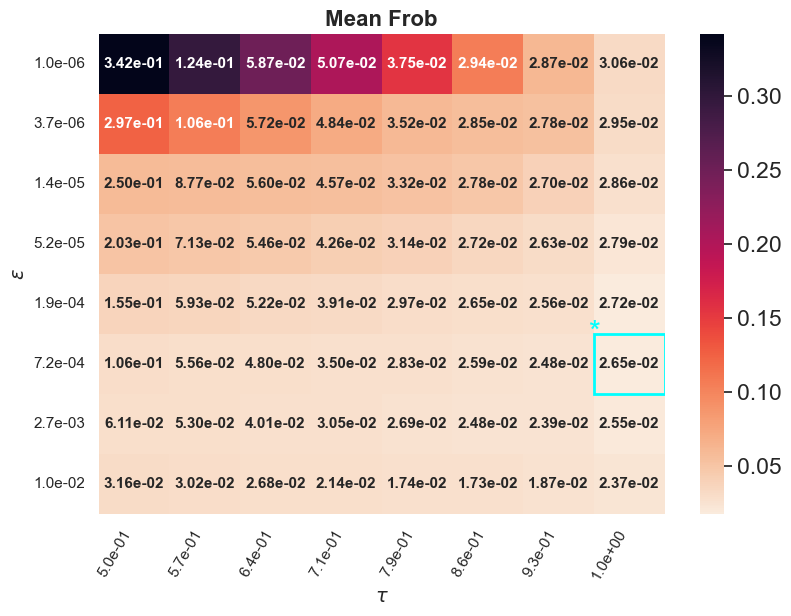

In [16]:
results_df["mean_wot_Frob"] = results_df[["mean_wot_12_Frob", "mean_wot_23_Frob"]].mean(axis=1)
plot_heatmap(results_df, "mean_wot_Frob", "Mean Frob")
results_df

In [17]:
WOT_eps_list

[np.float64(1.0000000000000002e-06),
 np.float64(3.7275937203149406e-06),
 np.float64(1.3894954943731374e-05),
 np.float64(5.17947467923121e-05),
 np.float64(0.00019306977288832499),
 np.float64(0.0007196856730011514),
 np.float64(0.002682695795279725),
 np.float64(0.01)]

In [18]:
WOT_tau_list

[np.float64(0.499995),
 np.float64(0.5714228571428571),
 np.float64(0.6428507142857143),
 np.float64(0.7142785714285714),
 np.float64(0.7857064285714286),
 np.float64(0.8571342857142857),
 np.float64(0.9285621428571429),
 np.float64(0.99999)]

In [20]:
results_df.to_csv(fh_save_metrics + 'wot_grid_search.csv', index=False)